# Apr 20th, 2022 (tSNR masks, many plot funcs)

**Motivation**: Here is a short list of updates contained here:
- plot_tsnr_ca makes nice comprehensive plot of CA tsnr analysis
- Run load_tsnr() to compute and save tSNR npy files for later use
- BOLD tsnr plots including Avg and Percent of voxels above certain kappa
- Study of how filtered voxels look like on ctx, ctx-subset, and ctx-lite (only accepted regions)
- Distribution of rois that get filtered at certain q value (BOLD), i.e. how many runs they are completely missing from?
- Finally, plotting tsnr masks as computed by reg.get_tsnr_masks() that will be used in reg.organize_func()
<br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def plot_tsnr_ca(mice, key, figsize=(12, 8), highpass: bool = False):
    set_style()
    results = load_tsnr(mice, key, 'ca2')
    if results is None:
        return None, None
    
    m = ~np.isnan(results['tSNR'])
    mu, sd, tsnr, m = filter_boundaries(
        [results['mu'], results['sd'], results['tSNR'], m], m)
    mu = np.abs(mu)
    # if abs_val:
    #     if (mu < 0).sum() > (mu > 0).sum():
    #         mu *= -1
    #     if (tsnr < 0).sum() > (tsnr > 0).sum():
    #         tsnr *= -1
    if (tsnr < 0).sum() > (tsnr > 0).sum():
        reverse = True
        thres = np.nanquantile(tsnr, 0.95)
    else:
        reverse = False
        thres = np.nanquantile(tsnr, 0.05)

    fig = plt.figure(
        figsize=figsize,
        constrained_layout=True,
    )
    gspec = GridSpec(
        nrows=4,
        ncols=6,
        height_ratios=[1.1] + [1] * 3,
        width_ratios=[1] + [1.3] + [1] * 4,
    )
    ax = fig.add_subplot(gspec[0, :])
    # ax.plot(gs_full, color='yellow', alpha=0.7, lw=0.8)
    ax.plot(results['gs'], color='k', alpha=1.0, lw=0.8, label='GS')
    # ax.plot(gs_bad, color='r',  alpha=0.6, lw=0.8, label='GS bad')
    ax.legend()
    ax.grid()

    data2p = {
        r'$\mu$': mu,
        r'$\sigma$': sd,
        r'$tSNR = \frac{|\mu|}{\sigma}$': tsnr,
    }
    for i, (lbl, x2p) in enumerate(data2p.items(), start=1):
        ax = fig.add_subplot(gspec[i, 0])
        ax.imshow(x2p, cmap='Spectral' if 'tSNR' in lbl else 'rocket')
        ax.set_ylabel(lbl, labelpad=10, fontsize=15)
        remove_ticks(ax)

        ax_hist = fig.add_subplot(gspec[i, 1])
        sns.histplot(x2p[m], kde=True, color='dimgrey', ax=ax_hist)
        ax_hist.tick_params(axis='y', labelleft=False)
        ax_hist.set_ylabel('')

        for j, q in enumerate([0.01, 0.03, 0.05, 0.10]):
            ax = fig.add_subplot(gspec[i, 2 + j])
            if 'tSNR' in lbl:
                if reverse:
                    thres = np.quantile(x2p[m], 1 - q)
                    good_pix = x2p < thres
                else:
                    thres = np.quantile(x2p[m], q)
                    good_pix = x2p > thres
            else:
                thres = np.quantile(x2p[m], 1 - q)
                good_pix = x2p < thres
            ax_hist.axvline(thres, color=f'C{j}', lw=1.2, ls='--')
            ax.imshow(m * good_pix, cmap=sns.dark_palette(f'C{j}', as_cmap=True, reverse=False))
            ax.set_ylabel(f'thres = {thres:0.2f}', fontsize=11)
            if 'tSNR' in lbl:
                ax.set_xlabel(f"q = {q}", fontsize=15)
            remove_ticks(ax)
            
    title = key
    if reverse:
        title += ' (reversed)'
    if highpass:
        title += "   .  .  .   HP (0.001 Hz)"
    sup = fig.suptitle(title, fontsize=14, y=0.93)
    plt.close()
    
    return fig, sup

## Mice

In [3]:
mice = Mice(128, load_allen=True, load_parcel=True)
mice.setup_anat_data()
mice.setup_preproc_data(ca_raw=True, bold_raw=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [4]:
from register.register import Register, reset_ants_img, load_tsnr, compute_tsnr_mask

## CA

In [4]:
%%time

for key, (sub, ses, run) in mice.looper.items():
    if run == -1:
        continue
    ca = load_tsnr(mice, key, 'ca2')
    bo = load_tsnr(mice, key, 'bold')
    
    if ca is None:
        print(f"[CA] run missing: {key}")
    if bo is None:
        print(f"[BO] run missing: {key}")

[CA] run missing: sub-SLC03_ses-1_run-1

[BO] run missing: sub-SLC03_ses-1_run-1

[CA] run missing: sub-SLC03_ses-2_run-1

[CA] run missing: sub-SLC03_ses-2_run-6

[CA] run missing: sub-SLC04_ses-3_run-3

[CA] run missing: sub-SLC04_ses-3_run-7

[BO] run missing: sub-SLC05_ses-1_run-5

[CA] run missing: sub-SLC05_ses-3_run-5

[CA] run missing: sub-SLC06_ses-3_run-2

[BO] run missing: sub-SLC06_ses-3_run-2

[CA] run missing: sub-SLC08_ses-1_run-7

[BO] run missing: sub-SLC08_ses-1_run-7

CPU times: user 1h 9min 18s, sys: 21min 33s, total: 1h 30min 51s
Wall time: 1h 30min 49s


In [5]:
set_style()

save_dir = pjoin(_fig_dir, 'quality_control', 'CA2')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/quality_control/CA2'

In [6]:
%%time

looper = itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids)
for sub, ses in looper:
    figs, sups = [], []
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        fig, sup = plot_tsnr_ca(mice, key)
        figs.append(fig)
        sups.append(sup)
    file = pjoin(save_dir, f"{mice.get_key(sub, ses)}.pdf")
    save_fig(figs, sups, file, multi=True)

CPU times: user 26min 6s, sys: 34.5 s, total: 26min 40s
Wall time: 4min 59s


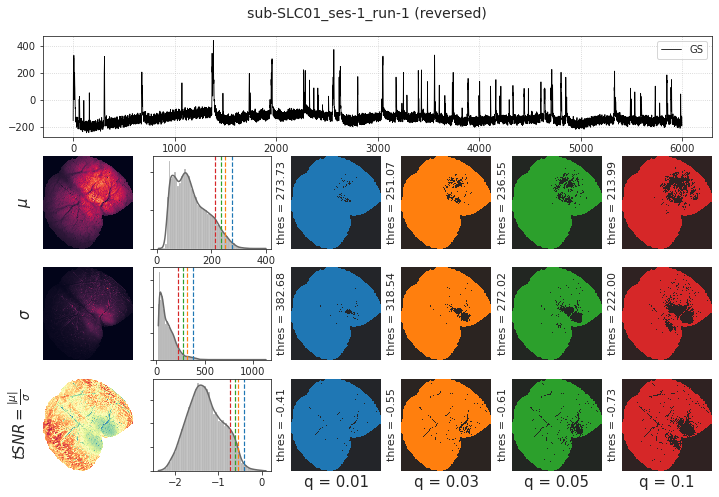

In [8]:
key = 'sub-SLC01_ses-1_run-1'
fig, sup = plot_tsnr_ca(mice, key)
fig

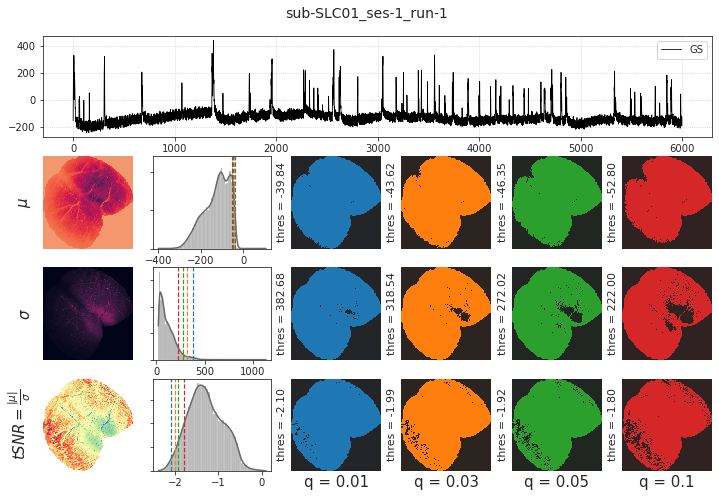

In [5]:
key = 'sub-ddSLC01_ses-1_run-1'
fig, sup = plot_tsnr_ca(mice, key)
fig

In [63]:
ca = load_tsnr(mice, key, 'ca2')

In [64]:
x = ca['tSNR']
(x < 0).sum(), (x > 0).sum()

(22691, 1)

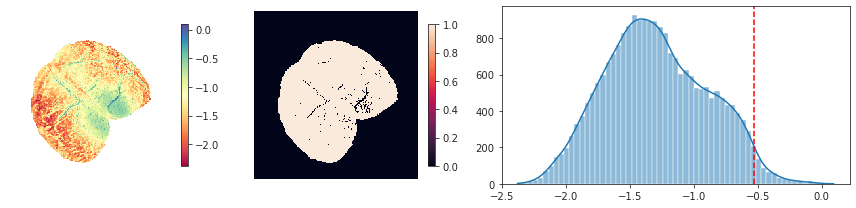

In [61]:
fig, axes = create_figure(1, 3, (12, 3), width_ratios=[1, 1, 1.7])

im = axes[0].imshow(ca['tSNR'], cmap='Spectral')
plt.colorbar(im, ax=axes[0], shrink=0.8)

q = np.nanquantile(ca['tSNR'][np.isfinite(ca['tSNR'])], 0.975)
im = axes[1].imshow(ca['tSNR'] < q)
plt.colorbar(im, ax=axes[1], shrink=0.8)

remove_ticks(axes[:2])

sns.histplot(ca['tSNR'][np.isfinite(ca['tSNR'])], kde=True, ax=axes[2])
axes[2].axvline(q, ls='--', color='r')
axes[2].set_ylabel('')
plt.show()

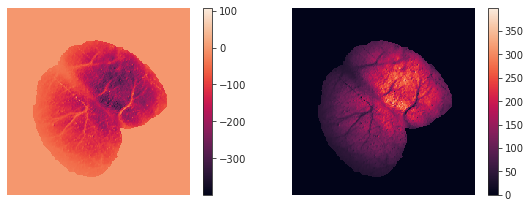

In [62]:
fig, axes = create_figure(1, 2, (8, 3))

im = axes[0].imshow(ca['mu'])
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(np.abs(ca['mu']))
plt.colorbar(im, ax=axes[1])

remove_ticks(axes)
plt.show()

## BOLD

### Brief overview of obj -> indiv

In [35]:
structs = mice.al.get_major_structs()
obj_ids = mice.al.get(structs)
obj_ids = dict(zip(obj_ids['acronym'], obj_ids['id']))
obj_ids = {obj_ids[s]: s for s in structs}

key = 'sub-SLC10_ses-2'
file = f"{key}_space-indiv3d_brain.nii.gz"
file = pjoin(mice.cfg.masks_dir, file)
obj = ants.image_read(file).numpy().astype(int)

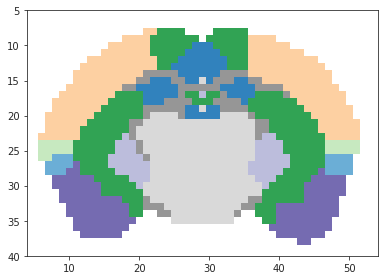

In [41]:
fig, ax = create_figure()
ax.imshow(mwh(obj[..., 40].T == 0, obj[..., 40].T), cmap='tab20c')
ax.set_ylim(40, 5)
ax.set_xlim(4, 54)
plt.show()

In [42]:
indiv = mice.T1w[key].load_ants()
indiv *= mice.mask3d[key].load_ants()

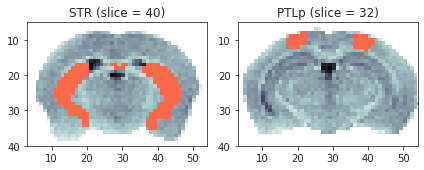

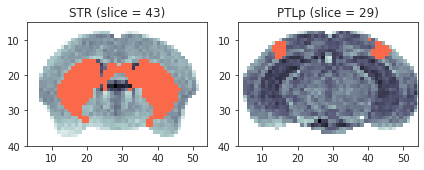

In [66]:
fig, axes = create_figure(1, 2, (6, 4))
i = 40
ax = axes[0]
ax.imshow(mwh(indiv[..., i].T == 0, indiv[..., i].T), cmap='bone_r')
idx = next(i for i, s in obj_ids.items() if s == 'STR')
x2p = (obj == idx)[..., i].T
ax.imshow(mwh(x2p == 0, x2p.astype(float) * 0.5), cmap='Reds', vmin=0, vmax=1)
ax.set_title(f'STR (slice = {i})')
ax.set_ylim(40, 5)
ax.set_xlim(3, 54)

i = 32
ax = axes[1]
ax.imshow(mwh(indiv[..., i].T == 0, indiv[..., i].T), cmap='bone_r')
idx = next(i for i, s in obj_ids.items() if s == 'PTLp')
x2p = (obj == idx)[..., i].T
ax.imshow(mwh(x2p == 0, x2p.astype(float) * 0.5), cmap='Reds', vmin=0, vmax=1)
ax.set_title(f'PTLp (slice = {i})')
ax.set_ylim(40, 5)
ax.set_xlim(3, 54)

plt.show()


fig, axes = create_figure(1, 2, (6, 4))
i = 43
ax = axes[0]
ax.imshow(mwh(indiv[..., i].T == 0, indiv[..., i].T), cmap='bone_r')
idx = next(i for i, s in obj_ids.items() if s == 'STR')
x2p = (obj == idx)[..., i].T
ax.imshow(mwh(x2p == 0, x2p.astype(float) * 0.5), cmap='Reds', vmin=0, vmax=1)
ax.set_title(f'STR (slice = {i})')
ax.set_ylim(40, 5)
ax.set_xlim(3, 54)

i = 29
ax = axes[1]
ax.imshow(mwh(indiv[..., i].T == 0, indiv[..., i].T), cmap='bone_r')
idx = next(i for i, s in obj_ids.items() if s == 'PTLp')
x2p = (obj == idx)[..., i].T
ax.imshow(mwh(x2p == 0, x2p.astype(float) * 0.5), cmap='Reds', vmin=0, vmax=1)
ax.set_title(f'PTLp (slice = {i})')
ax.set_ylim(40, 5)
ax.set_xlim(3, 54)

plt.show()

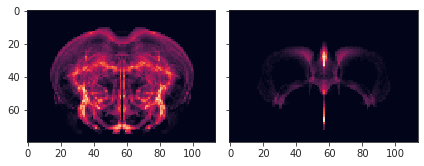

In [67]:
ft = mice.al.get_masks('fiber tracts')
vs = mice.al.get_masks('VS')

fig, axes = create_figure(1, 2, (6, 4), 'all', 'all')
axes[0].imshow(ft.mean(0))
axes[1].imshow(vs.mean(0))
plt.show()

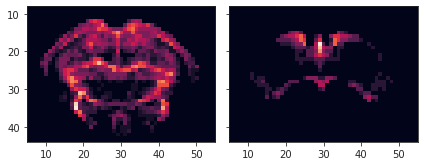

In [68]:
fig, axes = create_figure(1, 2, (6, 4), 'all', 'all')
axes[0].imshow((obj == next(i for i, s in obj_ids.items() if s == 'fiber tracts')).mean(-1).T)
axes[1].imshow((obj == next(i for i, s in obj_ids.items() if s == 'VS')).mean(-1).T)
axes[1].set_ylim(44, 8)
axes[1].set_xlim(5, 55)
plt.show()

In [69]:
for (i1, s1), (i2, s2) in itertools.combinations(obj_ids.items(), 2):
    m1 = obj == i1
    m2 = obj == i2
    
    if overlap_score(m1 > 0, m2 > 0):
        print(k1, k2, np.logical_and(m1 > 0, m2 > 0).sum())
    if np.logical_and(m1 > 0, m2 > 0).sum():
        print(k1, k2, np.logical_and(m1 > 0, m2 > 0).sum())

## tSNR plots

In [5]:
structs = mice.al.get_major_structs()
obj_ids = mice.al.get(structs)
obj_ids = dict(zip(obj_ids['acronym'], obj_ids['id']))
obj_ids = {obj_ids[s]: s for s in structs}

In [6]:
tsnr = {}
for key, (_, _, run) in mice.looper.items():
    if run == -1:
        continue
    results = load_tsnr(mice, key, 'bold')
    if results is None:
        continue
    tsnr[key] = results['tSNR']
len(tsnr)

206

### Avg

In [161]:
%%time

dlist = []
looper = itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids)
for sub, ses in looper:
    key = mice.get_key(sub, ses)
    f = f"{key}_space-indiv3d_brain.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    obj = ants.image_read(f).numpy().astype(int)

    f = f"{key}_space-indiv3d_hemis.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    hemis = ants.image_read(f).numpy().astype(int)

    ml = hemis == 1
    mr = hemis == 2

    masks = {
        s: obj == i for
        i, s in obj_ids.items()
    }
    masks = {
        'Brain': obj > 0,
        '~Brain': obj == 0,
        **masks,
    }
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        x = tsnr.get(key)
        if x is None:
            continue
        for k, m in masks.items():
            # Both hemis
            vals = x[m]
            data = {'mu': bn.nanmean(vals)}
            for q in [0.05, 0.25, 0.50, 0.75, 0.95]:
                data[q] = np.nanquantile(vals, q)
            dlist.append({
                'key': [key] * len(data),
                'label': [k] * len(data),
                'hemis': ['both'] * len(data),
                'n_vox': [m.sum()] * len(data),
                'measure': data.keys(),
                'value': data.values(),
            })
            # Left hemis
            _m = np.logical_and(m, ml)
            vals = x[_m]
            data = {'mu': bn.nanmean(vals)}
            for q in [0.05, 0.25, 0.50, 0.75, 0.95]:
                data[q] = np.nanquantile(vals, q)
            dlist.append({
                'key': [key] * len(data),
                'label': [k] * len(data),
                'hemis': ['left'] * len(data),
                'n_vox': [_m.sum()] * len(data),
                'measure': data.keys(),
                'value': data.values(),
            })
            # Right hemis
            _m = np.logical_and(m, mr)
            vals = x[_m]
            data = {'mu': bn.nanmean(vals)}
            for q in [0.05, 0.25, 0.50, 0.75, 0.95]:
                data[q] = np.nanquantile(vals, q)
            dlist.append({
                'key': [key] * len(data),
                'label': [k] * len(data),
                'hemis': ['right'] * len(data),
                'n_vox': [_m.sum()] * len(data),
                'measure': data.keys(),
                'value': data.values(),
            })
df = pd.DataFrame(merge_dicts(dlist))

CPU times: user 23.7 s, sys: 22.7 ms, total: 23.7 s
Wall time: 23.7 s


In [162]:
df.shape

(114948, 6)

In [163]:
fig_kws = {
    'transparent': True,
    'bbox_inches': 'tight',
}

In [164]:
set_style()

save_dir = pjoin(_fig_dir, 'quality_control', 'tSNR', 'BOLD')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/quality_control/tSNR/BOLD'

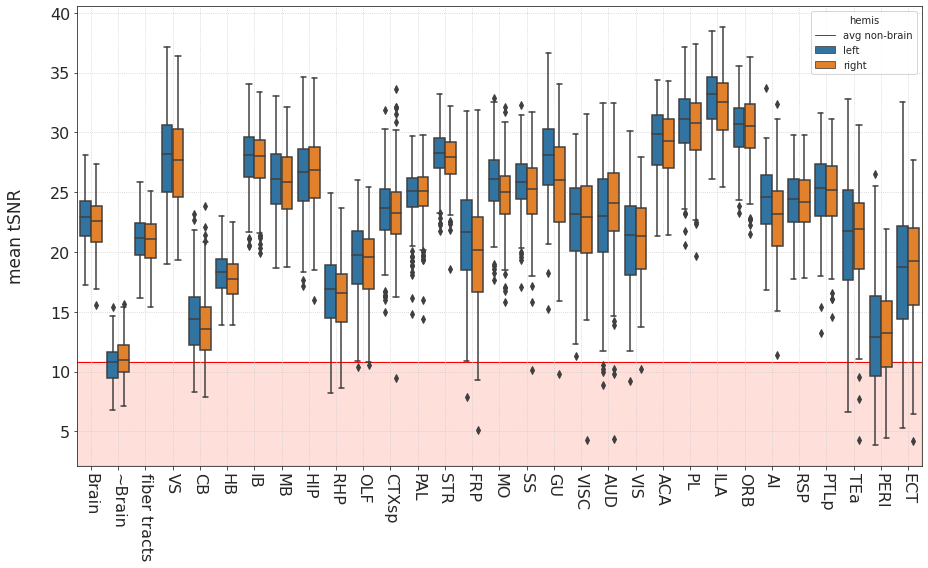

In [165]:
fig, ax = create_figure(figsize=(13, 8))

_df = df.loc[
    (df['hemis'] != 'both') &
    (df['measure'] == 'mu')
]
ax.axhline(
    y=_df.loc[_df['label'] == '~Brain', 'value'].mean(),
    color='r', alpha=1, ls='-', lw=1., zorder=0,
    label='avg non-brain',
)
ax.legend()

sns.boxplot(
    data=_df,
    x='label',
    hue='hemis',
    y='value',
    ax=ax,
)
ax.tick_params(axis='x', rotation=-90)
ax.tick_params('both', labelsize=16)
ax.set_ylabel(f'mean tSNR\n', fontsize=17)
ax.set_xlabel('')
ax.grid()

ylim_min, ylim_max = ax.get_ylim()
ax.axhspan(
    ymin=ylim_min,
    ymax=_df.loc[_df['label'] == '~Brain', 'value'].mean(),
    color='tomato', alpha=0.2, ls='-', lw=1.5, zorder=0,
)
ax.set_ylim((ylim_min, ylim_max))

name = 'Avg'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)

plt.show()

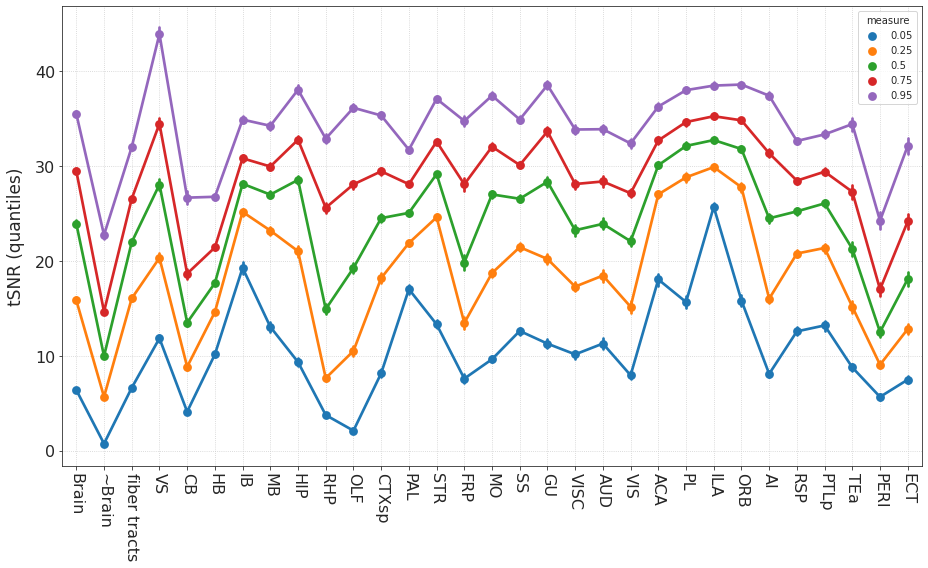

In [166]:
fig, ax = create_figure(figsize=(13, 8))

_df = df.loc[
    (df['hemis'] == 'both') &
    (df['measure'] != 'mu')
]
sns.pointplot(
    data=_df,
    x='label',
    y='value',
    hue='measure',
    ax=ax,
)
ax.tick_params(axis='x', rotation=-90)
ax.tick_params('both', labelsize=16)
ax.set_ylabel(f'tSNR (quantiles)', labelpad=10, fontsize=17)
ax.set_xlabel('')

name = 'Quantiles'
figname = f"{name}.pdf"
fig.savefig(pjoin(save_dir, figname), **fig_kws)

ax.grid()

### Percent

In [13]:
%%time

dlist = []
looper = itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids)
for sub, ses in looper:
    key = mice.get_key(sub, ses)
    f = f"{key}_space-indiv3d_brain.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    obj = ants.image_read(f).numpy().astype(int)

    f = f"{key}_space-indiv3d_hemis.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    hemis = ants.image_read(f).numpy().astype(int)

    ml = hemis == 1
    mr = hemis == 2

    masks = {
        s: obj == i for
        i, s in obj_ids.items()
    }
    masks = {
        'Brain': obj > 0,
        '~Brain': obj == 0,
        **masks,
    }
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        x = tsnr.get(key)
        if x is None:
            continue
        for k, m in masks.items():
            # Both hemis
            vals = x[m]
            data = {}
            for kappa in [10, 15, 20, 25]:
                below = bn.nansum(vals <= kappa)
                above = bn.nansum(vals > kappa)
                ratio = above / (above + below)
                data[kappa] = ratio * 100
            dlist.append({
                'key': [key] * len(data),
                'label': [k] * len(data),
                'hemis': ['both'] * len(data),
                'n_vox': [m.sum()] * len(data),
                'kappa': data.keys(),
                'value': data.values(),
            })
            # Left hemis
            _m = np.logical_and(m, ml)
            vals = x[_m]
            data = {}
            for kappa in [10, 15, 20, 25]:
                below = bn.nansum(vals <= kappa)
                above = bn.nansum(vals > kappa)
                ratio = above / (above + below)
                data[kappa] = ratio * 100
            dlist.append({
                'key': [key] * len(data),
                'label': [k] * len(data),
                'hemis': ['left'] * len(data),
                'n_vox': [_m.sum()] * len(data),
                'kappa': data.keys(),
                'value': data.values(),
            })
            # Right hemis
            _m = np.logical_and(m, mr)
            vals = x[_m]
            data = {}
            for kappa in [10, 15, 20, 25]:
                below = bn.nansum(vals <= kappa)
                above = bn.nansum(vals > kappa)
                ratio = above / (above + below)
                data[kappa] = ratio * 100
            dlist.append({
                'key': [key] * len(data),
                'label': [k] * len(data),
                'hemis': ['right'] * len(data),
                'n_vox': [_m.sum()] * len(data),
                'kappa': data.keys(),
                'value': data.values(),
            })
df = pd.DataFrame(merge_dicts(dlist))

CPU times: user 16.1 s, sys: 27.5 ms, total: 16.1 s
Wall time: 16.1 s


In [14]:
set_style()

save_dir = pjoin(_fig_dir, 'quality_control', 'tSNR', 'BOLD')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/quality_control/tSNR/BOLD'

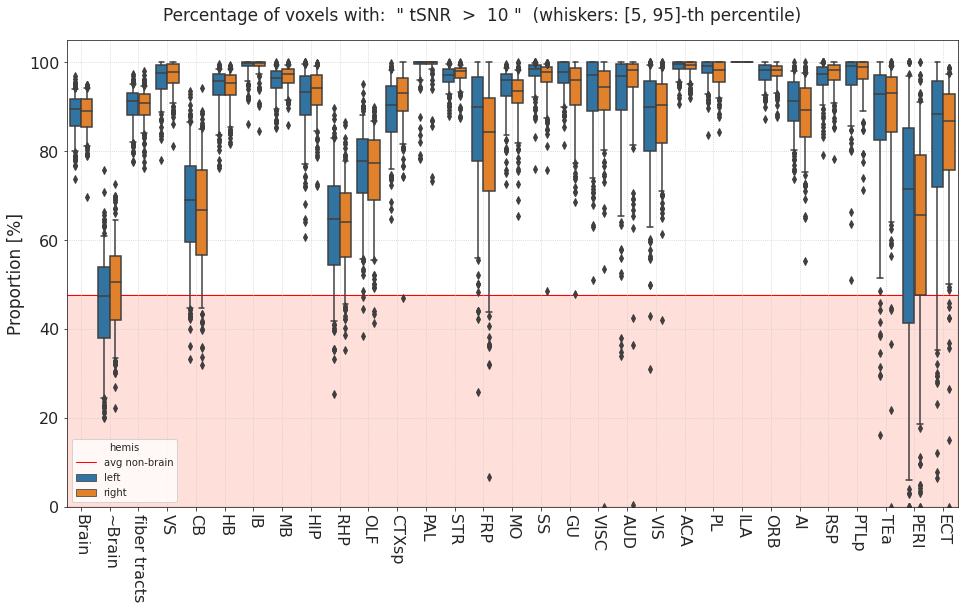

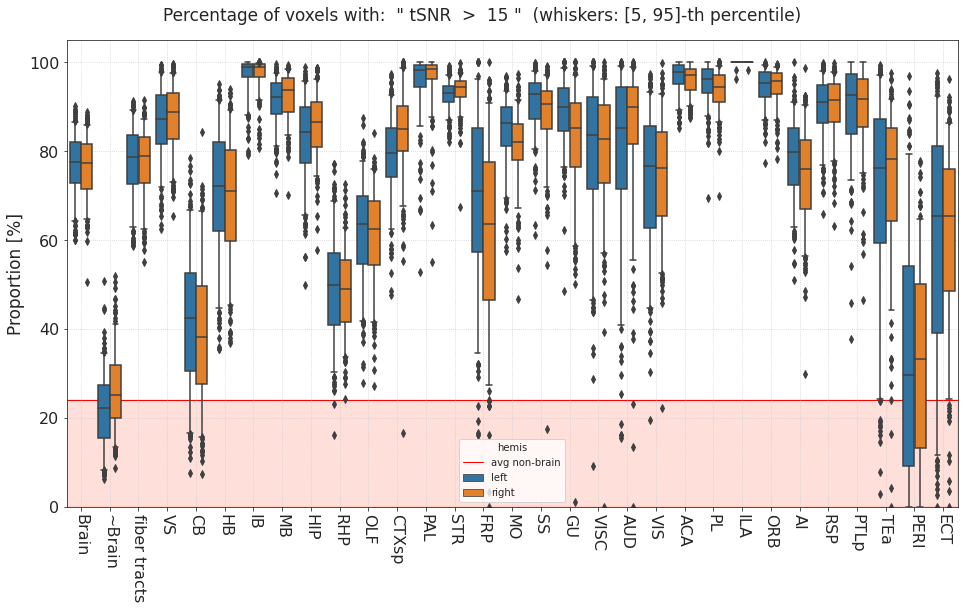

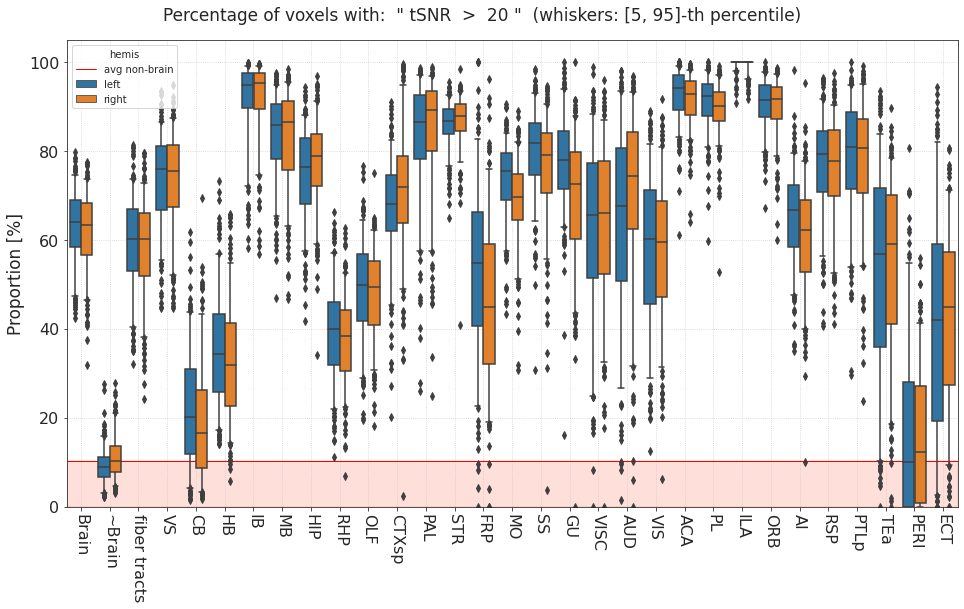

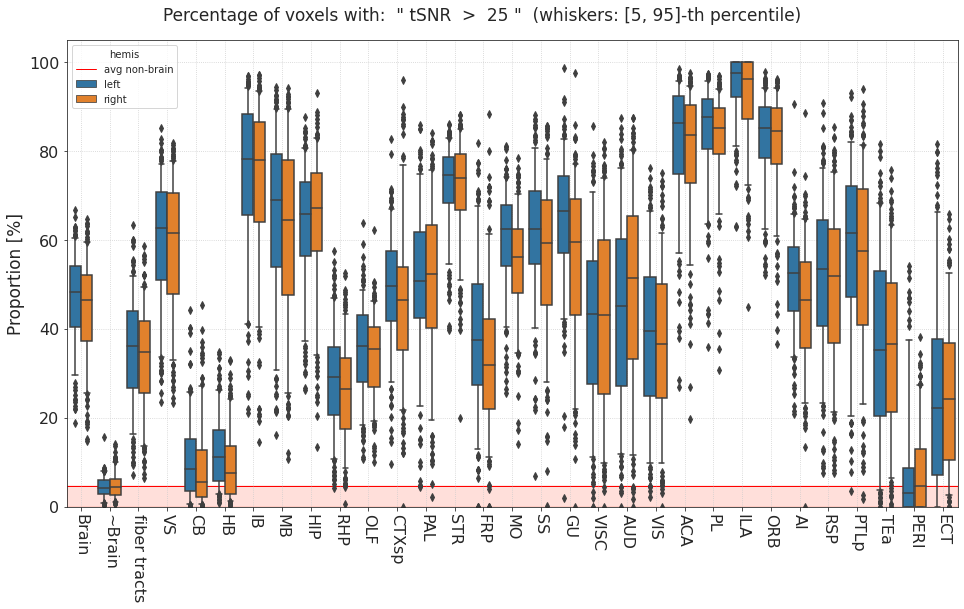

In [15]:
figs, sups = [], []
for kappa in df['kappa'].unique():
    _df = df.loc[
        (df['kappa'] == kappa) &
        (df['hemis'] != 'both')
    ]
    fig, ax = create_figure(1, 1, (13.5, 8.5))
    
    ax.axhline(
        y=_df.loc[_df['label'] == '~Brain', 'value'].mean(),
        color='r', alpha=1, ls='-', lw=1., zorder=0,
        label='avg non-brain',
    )
    ax.legend()
    
    sns.boxplot(
        data=_df,
        x='label',
        y='value',
        hue='hemis',
        whis=(5, 95),
        ax=ax,
    )
    ax.set_xlabel('')
    ax.set_ylabel(f"Proportion [%]", fontsize=17)
    ax.set_ylim(0, 105)
    ax.tick_params('x', rotation=-90)
    ax.tick_params('both', labelsize=16)
    ax.grid()

    ylim_min, ylim_max = ax.get_ylim()
    ax.axhspan(
        ymin=ylim_min,
        ymax=_df.loc[_df['label'] == '~Brain', 'value'].mean(),
        color='tomato', alpha=0.2, ls='-', lw=1.5, zorder=0,
    )
    ax.set_ylim((ylim_min, ylim_max))
    
    sup = f'Percentage of voxels with:  " tSNR  >  {kappa} "  (whiskers: [5, 95]-th percentile)'
    sup = fig.suptitle(sup, fontsize=17, y=0.99)
    figs.append(fig)
    sups.append(sup)

In [16]:
save_fig(figs, sups, pjoin(save_dir, 'Percent.pdf'), multi=True)

## Filter

In [272]:
sub, ses, run = 10, 2, 7
key = mice.get_key(sub, ses, run)

f = f"{mice.get_key(sub, ses)}_space-indiv3d_iso.nii.gz"
f = pjoin(mice.cfg.masks_dir, f)
ctx = ants.image_read(f).numpy().astype(bool)

<matplotlib.image.AxesImage object at 0x7fe38d9b3a90>

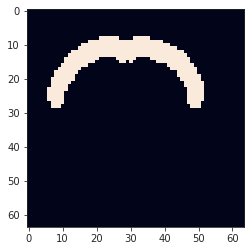

In [273]:
plt.imshow(ctx[..., 40].T)

In [274]:
vals = tsnr[key][ctx]
thres = np.nanquantile(vals, 0.1)
thres

15.760647392272949

<matplotlib.lines.Line2D object at 0x7fe38d9edd30>

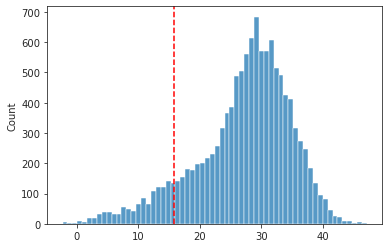

In [275]:
sns.histplot(vals)
plt.axvline(thres, color='r', ls='--')

In [276]:
mask = np.logical_and(ctx, tsnr[key] > thres)

<matplotlib.colorbar.Colorbar object at 0x7fe38d7a62e0>

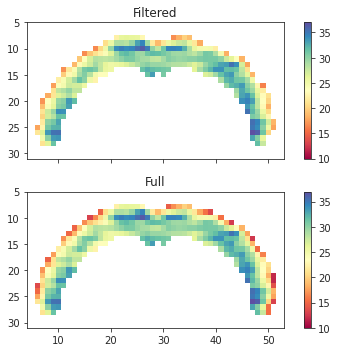

In [277]:
x2p = tsnr[key][..., 40].T

fig, axes = create_figure(2, 1, (6, 5), 'all', 'all')
ax = axes[0]
ax.set_title('Filtered')
im = ax.imshow(mwh(mask[..., 40].T == 0, x2p), cmap='Spectral', vmin=10, vmax=37)
plt.colorbar(im, ax=ax)
ax.set_ylim(31, 5)
ax.set_xlim(4, 53)

ax = axes[1]
ax.set_title('Full')
im = ax.imshow(mwh(ctx[..., 40].T == 0, x2p), cmap='Spectral', vmin=10, vmax=37)
plt.colorbar(im, ax=ax)

<matplotlib.image.AxesImage object at 0x7fe38d6d8250>

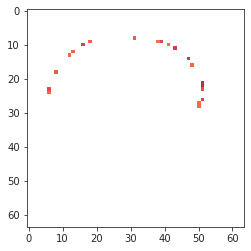

In [279]:
_m = np.logical_and(ctx, tsnr[key] <= thres)
plt.imshow(mwh(_m[..., 40].T == 0, x2p), cmap='Spectral', vmin=10, vmax=37)

In [259]:
avg = {}
for key, x in tsnr.items():
    f = mice.get_key(*mice.looper[key][:2])
    f = f"{f}_space-indiv3d_iso.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    ctx = ants.image_read(f).numpy().astype(bool)
    
    vals = tsnr[key][ctx]
    avg[key] = np.nanmean(vals)

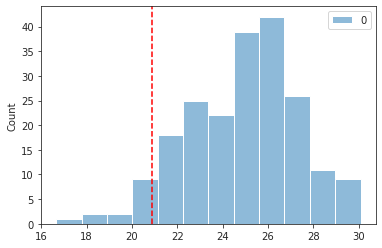

In [260]:
thres = np.nanquantile(list(avg.values()), 0.05)

sns.histplot(avg.values())
plt.axvline(thres, color='r', ls='--');

In [261]:
{k: v for k, v in avg.items() if v <= thres}

{
    'sub-SLC02_ses-1_run-2': 20.858215,
    'sub-SLC03_ses-3_run-2': 20.539764,
    'sub-SLC04_ses-1_run-1': 18.50225,
    'sub-SLC04_ses-1_run-2': 19.293167,
    'sub-SLC04_ses-1_run-3': 19.093952,
    'sub-SLC04_ses-1_run-4': 20.760414,
    'sub-SLC04_ses-1_run-5': 18.2398,
    'sub-SLC04_ses-2_run-5': 20.84518,
    'sub-SLC06_ses-2_run-3': 20.815731,
    'sub-SLC09_ses-3_run-3': 20.494656,
    'sub-SLC09_ses-3_run-7': 16.64998
}

In [262]:
q = 0.1
thres = {}
for key, x in tsnr.items():
    f = mice.get_key(*mice.looper[key][:2])
    f = f"{f}_space-indiv3d_iso.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    ctx = ants.image_read(f).numpy().astype(bool)
    
    vals = tsnr[key][ctx]
    thres[key] = np.nanquantile(vals, q)

<matplotlib.lines.Line2D object at 0x7fe38dee0790>

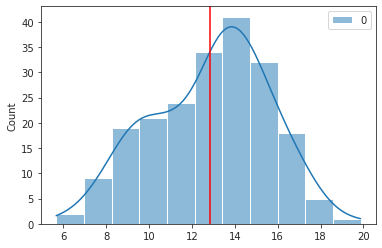

In [263]:
sns.histplot(thres.values(), kde=True)
plt.axvline(np.mean(list(thres.values())), color='r')

In [264]:
thres_fixed = 13
percent_removed = {}
for key, x in tsnr.items():
    f = mice.get_key(*mice.looper[key][:2])
    f = f"{f}_space-indiv3d_iso.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    ctx = ants.image_read(f).numpy().astype(bool)
    
    vals = tsnr[key][ctx]
    above = (vals > thres_fixed).sum()
    below = (vals <= thres_fixed).sum()
    ratio = below / (below + above)
    percent_removed[key] = ratio * 100

<matplotlib.lines.Line2D object at 0x7fe38e0618b0>

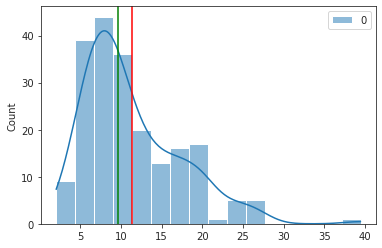

In [265]:
sns.histplot(percent_removed.values(), kde=True)
plt.axvline(np.mean(list(percent_removed.values())), color='r')
plt.axvline(np.median(list(percent_removed.values())), color='g')

<matplotlib.image.AxesImage object at 0x7fe395791220>

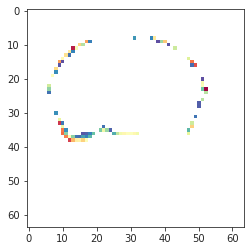

In [190]:
x2p = tsnr[key][..., 40].T
x2p = mwh(x2p > np.nanquantile(vals, 0.1), x2p)
plt.imshow(x2p, cmap='Spectral')

In [191]:
np.nanquantile(vals, 0.1)

15.760647392272949

## Plot filter

In [26]:
slices = [20, 7, 38]
slices_delta = [15, 4, -10]
width_ratios = [1.25] * 2 + [1.1] * 2 + [1] * 2
width_ratios = width_ratios * 2

q = 0.15

In [27]:
figs, sups = [], []
looper = itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids)
for sub, ses in looper:
    key = mice.get_key(sub, ses)
    f = f"{key}_space-indiv3d_iso.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    ctx = ants.image_read(f).numpy().astype(bool)
    mask = mice.mask3d[key].load_ants().numpy()
    t1w = mice.T1w[key].load_ants().numpy()
    t1w_tr, mask_tr, ctx_tr = filter_boundaries(
        [t1w, mask, ctx], mask)
    
    rows = {}
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        vals = tsnr.get(key)
        if vals is None:
            continue
        thres = np.nanquantile(vals[ctx], q)
        mgood = np.logical_and(ctx, tsnr[key] > thres)
        mfilt = np.logical_and(ctx, tsnr[key] <= thres)
        mgood_tr, mfilt_tr, tsnr_tr = filter_boundaries(
            [mgood, mfilt, vals], mask)

        rows[run] = (t1w_tr, mask_tr, ctx_tr, mgood_tr, mfilt_tr, tsnr_tr, thres)

    fig, axes = create_figure(
        nrows=len(rows),
        ncols=12,
        figsize=(13.5, 0.95 * len(rows)),
        width_ratios=width_ratios,
        tight_layout=False,
        constrained_layout=False,
    )
    for i, (run, data) in enumerate(rows.items()):
        t1w_tr, mask_tr, ctx_tr, mgood_tr, mfilt_tr, tsnr_tr, thres = data
    
        for j in range(3):
            ax = axes[i, 2 * j]
            s_ = slices[j]
            if i == 0:
                ax.set_title(s_)
            if j == 0:
                ax.set_ylabel(f'run-{run}\n' + r"$\kappa = $" + f"{thres:0.1f}", fontsize=10)

            _t, _m, _g, _f, _x = filter_boundaries(x_list=[
                t1w_tr.take(s_, j),
                mask_tr.take(s_, j),
                mgood_tr.take(s_, j),
                mfilt_tr.take(s_, j),
                tsnr_tr.take(s_, j),
            ], mask=mask_tr.take(s_, j))
            x2p = {
                'bg': mwh(_m == 0, _t),
                'good': mwh(_g == 0, _x),
                'filt': mwh(_f == 0, _x),
            }
            if j == 2:
                x2p = {k: x.T for k, x in x2p.items()}

            vmax = np.nanmax((tsnr_tr * ctx_tr).take(s_, j))
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['good'], cmap='Spectral', vmin=0, vmax=vmax)

            ax = axes[i, 2 * j + 1]
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['filt'], cmap='Spectral', vmin=0, vmax=vmax)

        for j in range(3):
            ax = axes[i, 6 + 2 * j]
            s_ = slices[j] + slices_delta[j]
            if i == 0:
                ax.set_title(s_)

            _t, _m, _g, _f, _x = filter_boundaries(x_list=[
                t1w_tr.take(s_, j),
                mask_tr.take(s_, j),
                mgood_tr.take(s_, j),
                mfilt_tr.take(s_, j),
                tsnr_tr.take(s_, j),
            ], mask=mask_tr.take(s_, j))
            x2p = {
                'bg': mwh(_m == 0, _t),
                'good': mwh(_g == 0, _x),
                'filt': mwh(_f == 0, _x),
            }
            if j == 2:
                x2p = {k: x.T for k, x in x2p.items()}

            vmax = np.nanmax((tsnr_tr * ctx_tr).take(s_, j))
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['good'], cmap='Spectral', vmin=0, vmax=vmax)

            ax = axes[i, 6 + 2 * j + 1]
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['filt'], cmap='Spectral', vmin=0, vmax=vmax)
    sup = fig.suptitle(mice.get_key(sub, ses), fontsize=17, y=1.005)
    figs.append(fig)
    sups.append(sup)
    remove_ticks(axes)
    plt.close()

In [28]:
save_fig(figs, sups, save_file=pjoin(save_dir, f'filt-ctx_q{q:0.2f}.pdf'), multi=True)

### Not do only surface

In [35]:
lite = ['VIS', 'RSP', 'PTLp', 'SS', 'MO', 'ACA', 'PL', 'FRP', 'AUD']
lite = [i for i, s in obj_ids.items() if s in lite]

slices = [20, 7, 38]
slices_delta = [15, 4, -10]
width_ratios = [1.25] * 2 + [1.1] * 2 + [1] * 2
width_ratios = width_ratios * 2

q = 0.05

In [36]:
figs, sups = [], []
looper = itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids)
for sub, ses in looper:
    key = mice.get_key(sub, ses)
    f = f"{key}_space-indiv3d_brain.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    obj = ants.image_read(f).numpy().astype(int)
    obj[~np.isin(obj, lite)] = 0
    obj = obj > 0
    
    mask = mice.mask3d[key].load_ants().numpy()
    t1w = mice.T1w[key].load_ants().numpy()
    t1w_tr, mask_tr, obj_tr = filter_boundaries(
        [t1w, mask, obj], mask)
    
    rows = {}
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        vals = tsnr.get(key)
        if vals is None:
            continue
        thres = np.nanquantile(vals[obj], q)
        mgood = np.logical_and(obj, tsnr[key] > thres)
        mfilt = np.logical_and(obj, tsnr[key] <= thres)
        mgood_tr, mfilt_tr, tsnr_tr = filter_boundaries(
            [mgood, mfilt, vals], mask)

        rows[run] = (t1w_tr, mask_tr, obj_tr, mgood_tr, mfilt_tr, tsnr_tr)

    fig, axes = create_figure(
        nrows=len(rows),
        ncols=12,
        figsize=(13.5, 0.95 * len(rows)),
        width_ratios=width_ratios,
        tight_layout=False,
        constrained_layout=False,
    )
    for i, (run, data) in enumerate(rows.items()):
        t1w_tr, mask_tr, obj_tr, mgood_tr, mfilt_tr, tsnr_tr = data
    
        for j in range(3):
            ax = axes[i, 2 * j]
            s_ = slices[j]
            if i == 0:
                ax.set_title(s_)
            if j == 0:
                ax.set_ylabel(f'run-{run}\n' + r"$\kappa = $" + f"{thres:0.1f}", fontsize=10)

            _t, _m, _g, _f, _x = filter_boundaries(x_list=[
                t1w_tr.take(s_, j),
                mask_tr.take(s_, j),
                mgood_tr.take(s_, j),
                mfilt_tr.take(s_, j),
                tsnr_tr.take(s_, j),
            ], mask=mask_tr.take(s_, j))
            x2p = {
                'bg': mwh(_m == 0, _t),
                'good': mwh(_g == 0, _x),
                'filt': mwh(_f == 0, _x),
            }
            if j == 2:
                x2p = {k: x.T for k, x in x2p.items()}

            vmax = np.nanmax((tsnr_tr * obj_tr).take(s_, j))
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['good'], cmap='Spectral', vmin=0, vmax=vmax)

            ax = axes[i, 2 * j + 1]
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['filt'], cmap='Spectral', vmin=0, vmax=vmax)

        for j in range(3):
            ax = axes[i, 6 + 2 * j]
            s_ = slices[j] + slices_delta[j]
            if i == 0:
                ax.set_title(s_)

            _t, _m, _g, _f, _x = filter_boundaries(x_list=[
                t1w_tr.take(s_, j),
                mask_tr.take(s_, j),
                mgood_tr.take(s_, j),
                mfilt_tr.take(s_, j),
                tsnr_tr.take(s_, j),
            ], mask=mask_tr.take(s_, j))
            x2p = {
                'bg': mwh(_m == 0, _t),
                'good': mwh(_g == 0, _x),
                'filt': mwh(_f == 0, _x),
            }
            if j == 2:
                x2p = {k: x.T for k, x in x2p.items()}

            vmax = np.nanmax((tsnr_tr * obj_tr).take(s_, j))
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['good'], cmap='Spectral', vmin=0, vmax=vmax)

            ax = axes[i, 6 + 2 * j + 1]
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['filt'], cmap='Spectral', vmin=0, vmax=vmax)
    sup = fig.suptitle(mice.get_key(sub, ses), fontsize=17, y=1.005)
    figs.append(fig)
    sups.append(sup)
    remove_ticks(axes)
    plt.close()

In [37]:
save_fig(figs, sups, save_file=pjoin(save_dir, f'filt-ctx-subset_q{q:0.2f}.pdf'), multi=True)

## Save final tSNR filtering mask plots: CA

In [7]:
meta_dir = pjoin(mice.cfg.base_dir, 'meta_info')
df = pd.read_csv(pjoin(meta_dir, 'QualityControl_CA.csv'))

In [8]:
collections.Counter(df['tSNR (q)']).most_common()[:10]

[
    (0.05, 49),
    (0.03, 39),
    (0.01, 38),
    (0.02, 28),
    (0.005, 10),
    (0.0, 3),
    (0.025, 1),
    (nan, 1),
    (nan, 1),
    (nan, 1)
]

In [9]:
collections.Counter(df['mu (1 - q)']).most_common()[:8]

[
    (0.03, 15),
    (0.01, 9),
    (0.05, 9),
    (0.02, 2),
    (nan, 1),
    (nan, 1),
    (nan, 1),
    (nan, 1)
]

In [68]:
save_dir = pjoin(_fig_dir, 'quality_control', 'tSNR', 'CA2')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/quality_control/tSNR/CA2'

In [69]:
fig_all, axes_all, sup_all = {}, {}, {}
for sub in mice.cfg.sub_ids:
    fig, axes = create_figure(
        ncols=mice.cfg.num_runs,
        nrows=mice.cfg.num_sessions * 2,
        figsize=(10, 1.3 * mice.cfg.num_runs),
        constrained_layout=False,
        tight_layout=False,
    )
    fig_all[sub] = fig
    axes_all[sub] = axes
    plt.close()

In [70]:
for i, row in df.iterrows():
    sub, ses, run, q_tsnr, q_mu, exclude, info = row
    key = mice.get_key(sub, ses, run)

    good_pix = compute_tsnr_mask(mice, key, q_tsnr, q_mu)
    if good_pix is None:
        continue

    _key = mice.get_key(*mice.looper[key][:2])
    m = mice.mask2d[_key].load_ants().numpy().astype(bool)
    good_pix, x, m = filter_boundaries(
        [good_pix, load_tsnr(mice, key, 'ca2')['tSNR'], m], m)

    ax = axes_all[sub][2 * (ses - 1), run - 1]
    ax.imshow(x, cmap='Spectral')
    
    if ses == 1:
        ax.set_title(f"run-{run}", fontsize=13, y=1.02)
    if run == 1:
        ax.set_ylabel(f"ses-{ses}", fontsize=13)
    
    ax = axes_all[sub][2 * (ses - 1) + 1, run - 1]
    ax.imshow(good_pix)
    ax.set_title(f"{(m.sum() - good_pix[m].sum()) / m.sum() * 100:0.0f} %", fontsize=9, y=0.94)
    if run == 1:
        ax.set_ylabel(f"ses-{ses}", fontsize=13)

    sup_all[sub] = fig_all[sub].suptitle(mice.get_key(sub), fontsize=17)
    remove_ticks(axes_all[sub])

In [71]:
save_fig(
    fig=list(fig_all.values()),
    sup=list(sup_all.values()),
    save_file=pjoin(save_dir, 'filt_q-var.pdf'),
    multi=True,
)

## Save final tSNR filtering mask plots: BOLD

In [13]:
reg = Register(mice)
reg.set_mode('bold')

In [14]:
output = reg.get_accepted_regions(cutoff=0, thres=0.2)

Name: cortex . . . a total of: 764 regions accepted, 4 regions rejected.
accept ratio: 99.48 %, reject ratio: 0.52 %, using a presence threshold of 20.0 %

Name: subcortex . . . a total of: 154 regions accepted, 1 regions rejected.
accept ratio: 99.35 %, reject ratio: 0.65 %, using a presence threshold of 20.0 %

In [15]:
remove_ctx = {k: v for k, v in output['cortex']['freq'].items() if v < 0.2}
remove_ctx

{362: 0.06666666666666667, 379: 0.0, 746: 0.06666666666666667, 763: 0.0}

In [16]:
remove_subctx = {k: v for k, v in output['subcortex']['freq'].items() if v < 0.2}
remove_subctx

{423: 0.0}

In [17]:
mice.parcel.decode(list(remove_ctx))

array([[  1, 106,   2],
       [  1, 123,   2],
       [  2, 106,   2],
       [  2, 123,   2]])

In [26]:
reg = Register(mice)
reg.set_mode('ca2')

In [27]:
output = reg.get_accepted_regions(cutoff=0, thres=0.2)

Name: cortex . . . a total of: 154 regions accepted, 102 regions rejected.
accept ratio: 60.16 %, reject ratio: 39.84 %, using a presence threshold of 20.0 %

<AxesSubplot:ylabel='Count'>

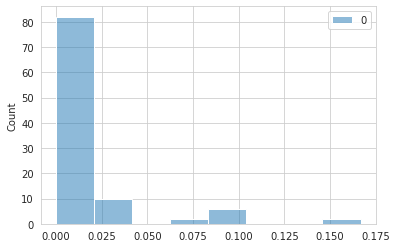

In [28]:
remove_ctx = {k: v for k, v in output['cortex']['freq'].items() if v < 0.2}
sns.histplot(remove_ctx.values())

In [29]:
output['subcortex']

{'freq': [], 'acc': [], 'rej': []}

In [30]:
regions_acc = output['cortex']['acc']
len(regions_acc)

154

In [31]:
f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parc_top = ants.image_read(f).numpy().astype(int)

<matplotlib.image.AxesImage object at 0x7fd61c3a5a60>

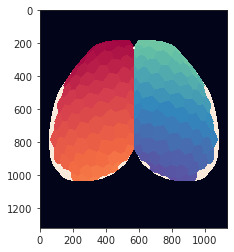

In [32]:
set_style()
plt.imshow(parc_top > 0)
plt.imshow(mwh(~np.isin(parc_top, regions_acc), parc_top), cmap='Spectral')

### Only surface, accepted regions, BOLD

In [57]:
save_dir = pjoin(_fig_dir, 'quality_control', 'tSNR', 'BOLD')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/quality_control/tSNR/BOLD'

In [58]:
slices = [20, 2, 38]
slices_delta = [15, 2, -10]
width_ratios = [1.25] * 2 + [1.1] * 2 + [1] * 2
width_ratios = width_ratios * 2

q = 0.15

In [59]:
figs, sups = [], []
looper = itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids)
for sub, ses in looper:
    key = mice.get_key(sub, ses)
    f = f"{key}_space-indiv3d_cortex.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    obj = ants.image_read(f).numpy().astype(int)
    obj[~np.isin(obj, regions_acc)] = 0
    obj = obj > 0
    
    mask = mice.mask3d[key].load_ants().numpy()
    t1w = mice.T1w[key].load_ants().numpy()
    t1w_tr, mask_tr, obj_tr = filter_boundaries(
        [t1w, mask, obj], mask)
    
    rows = {}
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        tsnr = load_tsnr(mice, key, 'bold')
        if tsnr is None:
            continue
        tsnr = tsnr.get('tSNR')
        thres = np.nanquantile(tsnr[obj], q)
        mgood = np.logical_and(obj, tsnr > thres)
        mfilt = np.logical_and(obj, tsnr <= thres)
        mgood_tr, mfilt_tr, tsnr_tr = filter_boundaries(
            [mgood, mfilt, tsnr], mask)

        rows[run] = (t1w_tr, mask_tr, obj_tr, mgood_tr, mfilt_tr, tsnr_tr)

    fig, axes = create_figure(
        nrows=len(rows),
        ncols=12,
        figsize=(13.5, 0.95 * len(rows)),
        width_ratios=width_ratios,
        tight_layout=False,
        constrained_layout=False,
    )
    for i, (run, data) in enumerate(rows.items()):
        t1w_tr, mask_tr, obj_tr, mgood_tr, mfilt_tr, tsnr_tr = data
    
        for j in range(3):
            ax = axes[i, 2 * j]
            s_ = slices[j]
            if i == 0:
                ax.set_title(s_)
            if j == 0:
                ax.set_ylabel(f'run-{run}\n' + r"$\kappa = $" + f"{thres:0.1f}", fontsize=10)

            _t, _m, _g, _f, _x = filter_boundaries(x_list=[
                t1w_tr.take(s_, j),
                mask_tr.take(s_, j),
                mgood_tr.take(s_, j),
                mfilt_tr.take(s_, j),
                tsnr_tr.take(s_, j),
            ], mask=mask_tr.take(s_, j))
            x2p = {
                'bg': mwh(_m == 0, _t),
                'good': mwh(_g == 0, _x),
                'filt': mwh(_f == 0, _x),
            }
            if j == 2:
                x2p = {k: x.T for k, x in x2p.items()}

            vmax = np.nanmax((tsnr_tr * obj_tr).take(s_, j))
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['good'], cmap='Spectral', vmin=0, vmax=vmax)

            ax = axes[i, 2 * j + 1]
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['filt'], cmap='Spectral', vmin=0, vmax=vmax)

        for j in range(3):
            ax = axes[i, 6 + 2 * j]
            s_ = slices[j] + slices_delta[j]
            if i == 0:
                ax.set_title(s_)

            _t, _m, _g, _f, _x = filter_boundaries(x_list=[
                t1w_tr.take(s_, j),
                mask_tr.take(s_, j),
                mgood_tr.take(s_, j),
                mfilt_tr.take(s_, j),
                tsnr_tr.take(s_, j),
            ], mask=mask_tr.take(s_, j))
            x2p = {
                'bg': mwh(_m == 0, _t),
                'good': mwh(_g == 0, _x),
                'filt': mwh(_f == 0, _x),
            }
            if j == 2:
                x2p = {k: x.T for k, x in x2p.items()}

            vmax = np.nanmax((tsnr_tr * obj_tr).take(s_, j))
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['good'], cmap='Spectral', vmin=0, vmax=vmax)

            ax = axes[i, 6 + 2 * j + 1]
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['filt'], cmap='Spectral', vmin=0, vmax=vmax)
    sup = fig.suptitle(mice.get_key(sub, ses), fontsize=17, y=1.005)
    figs.append(fig)
    sups.append(sup)
    remove_ticks(axes)
    plt.close()

In [60]:
save_fig(figs, sups, save_file=pjoin(save_dir, f'filt-ctx-lite_q{q:0.2}.pdf'), multi=True)

### Relationship between q and num ROIs deleted

In [84]:
dlist1, dlist2 = [], []
looper = itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids)
for sub, ses in tqdm(looper, total=30):
    key = mice.get_key(sub, ses)
    mask = mice.mask3d[key].load_ants().numpy()
    t1w = mice.T1w[key].load_ants().numpy()
    
    f = f"{key}_space-indiv3d_cortex.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    obj = ants.image_read(f).numpy().astype(int)
    obj[~np.isin(obj, regions_acc)] = 0

    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        tsnr = load_tsnr(mice, key, 'bold')
        if tsnr is None:
            continue
        tsnr = tsnr.get('tSNR')
        
        for q in [0.05, 0.1, 0.15, 0.2]:
            thres = np.nanquantile(tsnr[obj > 0], q)
            mgood = tsnr > thres

            scores = {}
            for r in regions_acc:
                scores[r] = overlap_score(mgood, obj == r)

            dlist1.append({
                'sub': [sub] * len(scores),
                'ses': [ses] * len(scores),
                'run': [run] * len(scores),
                'q': [q] * len(scores),
                'region': scores.keys(),
                'score': scores.values(),
            })
            
            num_deleted = (np.array(list(scores.values())) < 0.1).sum()
            dlist2.append({
                'sub': [sub],
                'ses': [ses],
                'run': [run],
                'thres': [thres],
                'q': [q],
                'num': [num_deleted],
            })
df1 = pd.DataFrame(merge_dicts(dlist1))
df2 = pd.DataFrame(merge_dicts(dlist2))

  0%|          | 0/30 [00:00<?, ?it/s]

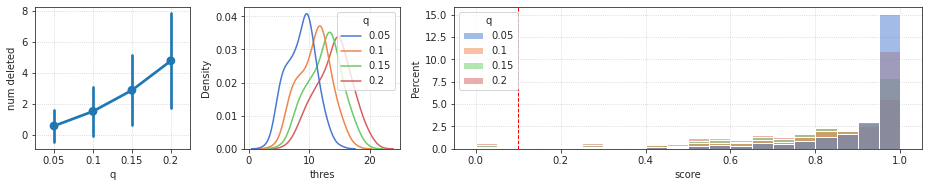

In [193]:
fig, axes = create_figure(1, 3, (13, 2.7), width_ratios=[1, 1, 3])

sns.pointplot(
    data=df2,
    x='q',
    y='num',
    ci='sd',
    ax=axes[0],
)
axes[0].set_ylabel('num deleted')

sns.kdeplot(
    data=df2,
    x='thres',
    hue='q',
    palette='muted',
    ax=axes[1],
)

sns.histplot(
    data=df1,
    x='score',
    hue='q',
    palette='muted',
    stat='percent',
    bins=np.linspace(0, 1, 21),
    ax=axes[2],
)
axes[2].axvline(0.1, c='r', ls='--', lw=1.)
add_grid(axes)
plt.show()

In [194]:
q = 0.10
_df = df1.loc[df1['q'] == q].drop(columns=['sub', 'ses', 'run', 'q', 'thres'])
num_runs = int(len(_df) / len(regions_acc))
num_runs

206

In [195]:
freq_deleted = {}
_df = _df.loc[_df['score'] == 0]
for r, x in collections.Counter(_df['region']).most_common():
    freq_deleted[r] = np.round(x / num_runs * 100, 1)

In [204]:
msg = ''
for r, x in freq_deleted.items():
    if x < 3:
        continue
    msg += f"region {r} \twas deleted from {x} % of runs\n"
print(msg)

region 397      was deleted from 25.2 % of runs
region 13       was deleted from 19.4 % of runs
region 123      was deleted from 8.7 % of runs
region 403      was deleted from 7.8 % of runs
region 116      was deleted from 6.3 % of runs
region 506      was deleted from 6.3 % of runs
region 122      was deleted from 3.9 % of runs
region 500      was deleted from 3.9 % of runs
region 396      was deleted from 3.4 % of runs

## TODO: this above thing but for 512

In [35]:
mice = Mice(512, load_allen=True)
mice.setup_anat_data()

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

Name: cortex . . . a total of: 542 regions accepted, 482 regions rejected.
accept ratio: 52.93 %, reject ratio: 47.07 %, using a presence threshold of 20.0 %

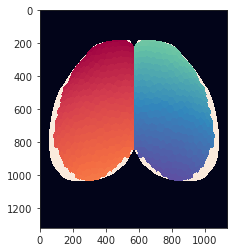

In [37]:
reg = Register(mice)
reg.set_mode('ca2')

output = reg.get_accepted_regions(cutoff=0, thres=0.2)
regions_acc = output['cortex']['acc']

f = 'parcel2d-top_10um.nii.gz'
f = pjoin(mice.cfg.parcel_dir, f)
parc_top = ants.image_read(f).numpy().astype(int)

set_style()
plt.imshow(parc_top > 0)
plt.imshow(mwh(~np.isin(parc_top, regions_acc), parc_top), cmap='Spectral')
plt.show()

In [38]:
dlist1, dlist2 = [], []
looper = itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids)
for sub, ses in tqdm(looper, total=30):
    key = mice.get_key(sub, ses)
    mask = mice.mask3d[key].load_ants().numpy()
    t1w = mice.T1w[key].load_ants().numpy()
    
    f = f"{key}_space-indiv3d_cortex.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    obj = ants.image_read(f).numpy().astype(int)
    obj[~np.isin(obj, regions_acc)] = 0

    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        tsnr = load_tsnr(mice, key, 'bold')
        if tsnr is None:
            continue
        tsnr = tsnr.get('tSNR')
        
        for q in [0.05, 0.1, 0.15, 0.2]:
            thres = np.nanquantile(tsnr[obj > 0], q)
            mgood = tsnr > thres

            scores = {}
            for r in regions_acc:
                scores[r] = overlap_score(mgood, obj == r)

            dlist1.append({
                'sub': [sub] * len(scores),
                'ses': [ses] * len(scores),
                'run': [run] * len(scores),
                'q': [q] * len(scores),
                'region': scores.keys(),
                'score': scores.values(),
            })
            
            num_deleted = (np.array(list(scores.values())) < 0.1).sum()
            dlist2.append({
                'sub': [sub],
                'ses': [ses],
                'run': [run],
                'thres': [thres],
                'q': [q],
                'num': [num_deleted],
            })
df1 = pd.DataFrame(merge_dicts(dlist1))
df2 = pd.DataFrame(merge_dicts(dlist2))

  0%|          | 0/30 [00:00<?, ?it/s]

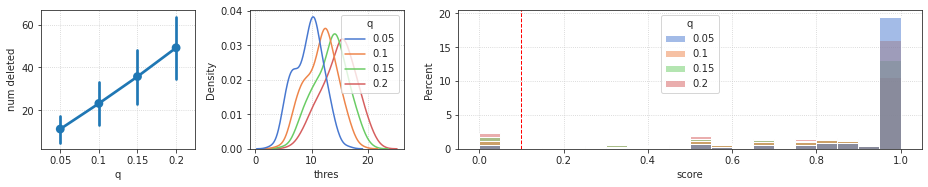

In [39]:
fig, axes = create_figure(1, 3, (13, 2.7), width_ratios=[1, 1, 3])

sns.pointplot(
    data=df2,
    x='q',
    y='num',
    ci='sd',
    ax=axes[0],
)
axes[0].set_ylabel('num deleted')

sns.kdeplot(
    data=df2,
    x='thres',
    hue='q',
    palette='muted',
    ax=axes[1],
)

sns.histplot(
    data=df1,
    x='score',
    hue='q',
    palette='muted',
    stat='percent',
    bins=np.linspace(0, 1, 21),
    ax=axes[2],
)
axes[2].axvline(0.1, c='r', ls='--', lw=1.)
add_grid(axes)
plt.show()

In [50]:
q = 0.1
_df = df1.loc[df1['q'] == q].drop(columns=['sub', 'ses', 'run', 'q'])
num_runs = int(len(_df) / len(regions_acc))
num_runs

206

In [51]:
freq_deleted = {}
_df = _df.loc[_df['score'] == 0]
for r, x in collections.Counter(_df['region']).most_common():
    freq_deleted[r] = np.round(x / num_runs * 100, 1)

In [52]:
msg = ''
for r, x in freq_deleted.items():
    if x < 10:
        continue
    msg += f"region {r} \twas deleted from {x} % of runs\n"
print(msg)

region 1593     was deleted from 46.1 % of runs
region 1582     was deleted from 45.1 % of runs
region 478      was deleted from 44.2 % of runs
region 66       was deleted from 38.3 % of runs
region 1602     was deleted from 36.4 % of runs
region 2014     was deleted from 35.4 % of runs
region 490      was deleted from 35.0 % of runs
region 2017     was deleted from 32.5 % of runs
region 456      was deleted from 32.5 % of runs
region 60       was deleted from 30.1 % of runs
region 491      was deleted from 29.6 % of runs
region 2032     was deleted from 29.6 % of runs
region 2002     was deleted from 29.1 % of runs
region 492      was deleted from 28.6 % of runs
region 487      was deleted from 28.2 % of runs
region 2018     was deleted from 27.7 % of runs
region 466      was deleted from 27.7 % of runs
region 1596     was deleted from 27.7 % of runs
region 2027     was deleted from 27.7 % of runs
region 480      was deleted from 26.7 % of runs
region 2028     was deleted from 26.2 % of runs
region 483      was deleted from 25.7 % of runs
region 496      was deleted from 25.7 % of runs
region 463      was deleted from 25.7 % of runs
region 57       was deleted from 25.2 % of runs
region 77       was deleted from 24.8 % of runs
region 2026     was deleted from 24.8 % of runs
region 489      was deleted from 24.3 % of runs
region 482      was deleted from 22.3 % of runs
region 481      was deleted from 21.8 % of runs
region 1613     was deleted from 21.4 % of runs
region 2023     was deleted from 21.4 % of runs
region 2016     was deleted from 20.9 % of runs
region 461      was deleted from 20.4 % of runs
region 2019     was deleted from 19.9 % of runs
region 75       was deleted from 19.4 % of runs
region 476      was deleted from 19.4 % of runs
region 1648     was deleted from 19.4 % of runs
region 2012     was deleted from 18.0 % of runs
region 1633     was deleted from 17.5 % of runs
region 118      was deleted from 17.0 % of runs
region 436      was deleted from 17.0 % of runs
region 46       was deleted from 16.5 % of runs
region 1611     was deleted from 16.5 % of runs
region 2025     was deleted from 16.5 % of runs
region 467      was deleted from 16.5 % of runs
region 1997     was deleted from 16.5 % of runs
region 1739     was deleted from 16.0 % of runs
region 1977     was deleted from 16.0 % of runs
region 443      was deleted from 15.5 % of runs
region 1999     was deleted from 15.0 % of runs
region 1608     was deleted from 15.0 % of runs
region 138      was deleted from 15.0 % of runs
region 469      was deleted from 15.0 % of runs
region 1595     was deleted from 14.6 % of runs
region 475      was deleted from 14.6 % of runs
region 462      was deleted from 14.6 % of runs
region 2001     was deleted from 14.6 % of runs
region 2005     was deleted from 14.1 % of runs
region 1630     was deleted from 14.1 % of runs
region 1607     was deleted from 14.1 % of runs
region 1674     was deleted from 14.1 % of runs
region 203      was deleted from 14.1 % of runs
region 468      was deleted from 13.6 % of runs
region 56       was deleted from 13.1 % of runs
region 416      was deleted from 13.1 % of runs
region 80       was deleted from 12.6 % of runs
region 441      was deleted from 12.6 % of runs
region 1998     was deleted from 12.6 % of runs
region 225      was deleted from 12.6 % of runs
region 248      was deleted from 12.6 % of runs
region 59       was deleted from 12.1 % of runs
region 1784     was deleted from 12.1 % of runs
region 78       was deleted from 12.1 % of runs
region 179      was deleted from 11.7 % of runs
region 1610     was deleted from 11.7 % of runs
region 1992     was deleted from 11.7 % of runs
region 1606     was deleted from 11.2 % of runs
region 84       was deleted from 10.7 % of runs
region 244      was deleted from 10.7 % of runs
region 1625     was deleted from 10.7 % of runs
region 1616     was deleted from 10.2 % of runs
region 446      was deleted from 10.2 % of runs
region 1678     

## Finalize tsnr mask get

In [5]:
mice = Mice(128, load_allen=True)
mice.setup_anat_data()
reg = Register(mice)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [6]:
tsnr_masks = reg.get_tsnr_masks()
len(tsnr_masks['ca2']), len(tsnr_masks['bold'])

Name: cortex . . . a total of: 154 regions accepted, 102 regions rejected.
accept ratio: 60.16 %, reject ratio: 39.84 %, using a presence threshold of 20.0 %

(202, 206)

In [7]:
save_dir = pjoin(_fig_dir, 'quality_control', 'tSNR')
os.makedirs(save_dir, exist_ok=True)
save_dir

'/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/quality_control/tSNR'

### Save final tSNR masks: CA2

In [8]:
fig_all, axes_all, sup_all = {}, {}, {}
for sub in mice.cfg.sub_ids:
    fig, axes = create_figure(
        ncols=mice.cfg.num_runs,
        nrows=mice.cfg.num_sessions * 2,
        figsize=(10, 1.3 * mice.cfg.num_runs),
        constrained_layout=False,
        tight_layout=False,
    )
    fig_all[sub] = fig
    axes_all[sub] = axes
    plt.close()

In [9]:
for key, tsnr_m in tsnr_masks['ca2'].items():
    sub, ses, run = mice.looper[key]
    
    _key = mice.get_key(sub, ses)
    m = mice.mask2d[_key].load_ants().numpy().astype(bool)
    good, x, m = filter_boundaries(
        [tsnr_m, load_tsnr(mice, key, 'ca2')['tSNR'], m], m)

    ax = axes_all[sub][2 * (ses - 1), run - 1]
    ax.imshow(x, cmap='Spectral')
    
    if ses == 1:
        ax.set_title(f"run-{run}", fontsize=13, y=1.02)
    if run == 1:
        ax.set_ylabel(f"ses-{ses}", fontsize=13)
    
    ax = axes_all[sub][2 * (ses - 1) + 1, run - 1]
    ax.imshow(good)
    ax.set_title(f"{(m.sum() - good[m].sum()) / m.sum() * 100:0.0f} %", fontsize=9, y=0.94)
    if run == 1:
        ax.set_ylabel(f"ses-{ses}", fontsize=13)

    sup_all[sub] = fig_all[sub].suptitle(mice.get_key(sub), fontsize=17)
    remove_ticks(axes_all[sub])

In [10]:
save_fig(
    fig=list(fig_all.values()),
    sup=list(sup_all.values()),
    save_file=pjoin(save_dir, f'tSNR-masks_CA2.pdf'),
    multi=True,
)

### Save final tSNR masks: BOLD

In [11]:
reg = Register(mice)
reg.set_mode('ca2')
regions_acc = reg.get_accepted_regions()['cortex']['acc']

Name: cortex . . . a total of: 154 regions accepted, 102 regions rejected.
accept ratio: 60.16 %, reject ratio: 39.84 %, using a presence threshold of 20.0 %

In [12]:
slices = [20, 2, 38]
slices_delta = [15, 2, -10]
width_ratios = [1.25] * 2 + [1.1] * 2 + [1] * 2
width_ratios = width_ratios * 2

In [13]:
figs, sups = [], []
looper = itertools.product(mice.cfg.sub_ids, mice.cfg.ses_ids)
for sub, ses in looper:
    key = mice.get_key(sub, ses)
    f = f"{key}_space-indiv3d_cortex.nii.gz"
    f = pjoin(mice.cfg.masks_dir, f)
    obj = ants.image_read(f).numpy().astype(int)
    obj[~np.isin(obj, regions_acc)] = 0
    obj = obj > 0
    
    mask = mice.mask3d[key].load_ants().numpy()
    t1w = mice.T1w[key].load_ants().numpy()
    t1w_tr, mask_tr, obj_tr = filter_boundaries(
        [t1w, mask, obj], mask)
    
    rows = {}
    for run in mice.cfg.run_ids:
        key = mice.get_key(sub, ses, run)
        tsnr_m = tsnr_masks['bold'].get(key)
        if tsnr_m is None:
            continue
        mgood = np.logical_and(obj, tsnr_m)
        mfilt = np.logical_and(obj, ~tsnr_m)
        mgood_tr, mfilt_tr, tsnr_tr = filter_boundaries(
            [mgood, mfilt, load_tsnr(mice, key, 'bold')['tSNR']], mask)

        rows[run] = (t1w_tr, mask_tr, obj_tr, mgood_tr, mfilt_tr, tsnr_tr)

    fig, axes = create_figure(
        nrows=len(rows),
        ncols=12,
        figsize=(13.5, 0.95 * len(rows)),
        width_ratios=width_ratios,
        tight_layout=False,
        constrained_layout=False,
    )
    for i, (run, data) in enumerate(rows.items()):
        t1w_tr, mask_tr, obj_tr, mgood_tr, mfilt_tr, tsnr_tr = data
    
        for j in range(3):
            ax = axes[i, 2 * j]
            s_ = slices[j]
            if i == 0:
                ax.set_title(s_)
            if j == 0:
                percent_removed = mfilt_tr.sum() / (mfilt_tr.sum() + mgood_tr.sum())
                percent_removed *= 100
                ax.set_ylabel(f'run-{run}\n' + f"removed: {percent_removed:0.1f} %", fontsize=6)

            _t, _m, _g, _f, _x = filter_boundaries(x_list=[
                t1w_tr.take(s_, j),
                mask_tr.take(s_, j),
                mgood_tr.take(s_, j),
                mfilt_tr.take(s_, j),
                tsnr_tr.take(s_, j),
            ], mask=mask_tr.take(s_, j))
            x2p = {
                'bg': mwh(_m == 0, _t),
                'good': mwh(_g == 0, _x),
                'filt': mwh(_f == 0, _x),
            }
            if j == 2:
                x2p = {k: x.T for k, x in x2p.items()}

            vmax = np.nanmax((tsnr_tr * obj_tr).take(s_, j))
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['good'], cmap='Spectral', vmin=0, vmax=vmax)

            ax = axes[i, 2 * j + 1]
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['filt'], cmap='Spectral', vmin=0, vmax=vmax)

        for j in range(3):
            ax = axes[i, 6 + 2 * j]
            s_ = slices[j] + slices_delta[j]
            if i == 0:
                ax.set_title(s_)

            _t, _m, _g, _f, _x = filter_boundaries(x_list=[
                t1w_tr.take(s_, j),
                mask_tr.take(s_, j),
                mgood_tr.take(s_, j),
                mfilt_tr.take(s_, j),
                tsnr_tr.take(s_, j),
            ], mask=mask_tr.take(s_, j))
            x2p = {
                'bg': mwh(_m == 0, _t),
                'good': mwh(_g == 0, _x),
                'filt': mwh(_f == 0, _x),
            }
            if j == 2:
                x2p = {k: x.T for k, x in x2p.items()}

            vmax = np.nanmax((tsnr_tr * obj_tr).take(s_, j))
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['good'], cmap='Spectral', vmin=0, vmax=vmax)

            ax = axes[i, 6 + 2 * j + 1]
            ax.imshow(x2p['bg'], alpha=1, cmap='gray_r')
            ax.imshow(x2p['filt'], cmap='Spectral', vmin=0, vmax=vmax)
    sup = fig.suptitle(mice.get_key(sub, ses), fontsize=17, y=1.005)
    figs.append(fig)
    sups.append(sup)
    remove_ticks(axes)
    plt.close()

In [14]:
save_fig(figs, sups, save_file=pjoin(save_dir, f'tSNR-masks_BOLD.pdf'), multi=True)

## Non Brain:

In [95]:
a = tsnr * masks['~Brain']

(0.0, 62.0)

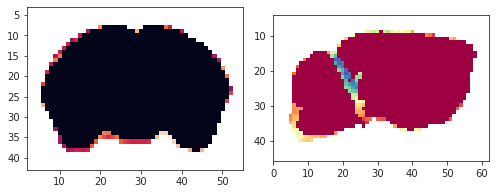

In [122]:
fig, axes = create_figure(1, 2, (7, 4))
axes[0].imshow(a[..., 40].T)
axes[0].set_ylim(43, 3)
axes[0].set_xlim(2, 55)
axes[1].imshow(a[40], cmap='Spectral')
axes[1].set_ylim(46, 4)
axes[1].set_xlim(0, 62)

<matplotlib.image.AxesImage object at 0x7fe397aa1ee0>

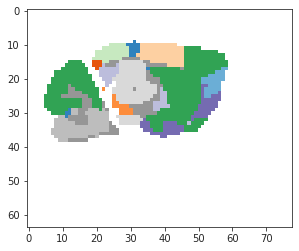

In [123]:
plt.imshow(mwh(obj[40] == 0, obj[40]), cmap='tab20c')